# Two Qubit Design

## Coupled Tee Construction

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import pyEPR as epr

In [4]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '10 mm'
design.chips.main.size['size_y'] = '10 mm'

design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

gui = MetalGUI(design)

In [5]:
design.delete_all_components()

In [6]:
design.delete_component('cpw_2')

09:18PM 25s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.


True

In [7]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 



options = dict(pad_width = '250 um',
pocket_width = '300 um',
pad_pocket_distance_top = '60 um',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10 um',
             pad_height = '20 um',
             pad_width = '100 um',
             pad_cpw_extent =  '10 um',
             pocket_rise = '0 um',
             cpw_extend = '5 um')))

q1 = TransmonPocket_Single(design,'Q1',options = dict(pos_x = '1 mm', 
                                                      pos_y = '0',
                                                      pad_height = '200 um', 
                                                      **options))
q2 = TransmonPocket_Single(design,'Q2',options = dict(pos_x = '0.39 mm', 
                                                      pos_y = '-0.7', 
                                                      pad_height = '220 um', 
                                                      **options))

gui.rebuild()
gui.zoom_on_components(['Q1','Q2'])

In [8]:
design.variables['cpw_width']

'15 um'

In [9]:
design.parse_value(q1.options.pos_x)

1

In [10]:
# design.delete_all_components()

# prime_width='10um',
#                            prime_gap='6um',
#                            second_width='10um',
#                            second_gap='6um',
#                            coupling_space='3um',
#                            coupling_length='100um',
#                            down_length='100um',
#                            fillet='25um',
#                            mirror=False,
#                            open_termination=True)

TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['cpw_width'],
               second_gap = design.variables['cpw_gap'],
               downlength = '30um',
               coupling_space = '5um',
               open_termination=False)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1.35 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.15 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', mirror = True, **TQ_options))

gui.rebuild()
gui.autoscale()

In [11]:
import numpy as np
from collections import OrderedDict

def pins_for_spiral(radius,gap,n,dis = ('0','0'),no_last = False):
    spiral_list = OrderedDict()
    radius = design.parse_value(radius)
    gap = design.parse_value(gap)
    x = design.parse_value(dis[0])
    y = design.parse_value(dis[1])
    for step in range(n):
        point_value = radius / 2 + step * (0 + gap)
        spiral_list[step*4] = np.array([x+point_value, y-point_value])
        spiral_list[step*4+1] = np.array([x-point_value, y-point_value])
        spiral_list[step*4+2] = np.array([x-point_value, y+point_value])
        if no_last & (step==n-1):
            # spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])
            break
        spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])

    point_value = radius / 2 + (step + 1) * (0 + gap)
    # spiral_list[step*4+4] = np.array([-point_value, -point_value])
    return(spiral_list)

In [12]:
anchors_1 = pins_for_spiral('0.4 mm','0.1 mm',2,dis = (q1.options.pos_x,q1.options.pos_y))
anchors_2 = pins_for_spiral('0.4 mm','0.1 mm',2,dis = (q2.options.pos_x,q2.options.pos_y),no_last=True)
print(anchors_1)
print(anchors_2)

OrderedDict([(0, array([ 1.2, -0.2])), (1, array([ 0.8, -0.2])), (2, array([0.8, 0.2])), (3, array([1.3, 0.2])), (4, array([ 1.3, -0.3])), (5, array([ 0.7, -0.3])), (6, array([0.7, 0.3])), (7, array([1.4, 0.3]))])
OrderedDict([(0, array([ 0.59, -0.9 ])), (1, array([ 0.19, -0.9 ])), (2, array([ 0.19, -0.5 ])), (3, array([ 0.69, -0.5 ])), (4, array([ 0.69, -1.  ])), (5, array([ 0.09, -1.  ])), (6, array([ 0.09, -0.4 ]))])


In [13]:
options_1 = Dict(total_length='4 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='20 um',
        lead = dict(start_straight='20 um', end_straight = '0 um'),
        anchors = anchors_1,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

options_2 = Dict(total_length='3.5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='20 um',
        lead = dict(start_straight='20 um', end_straight = '0 um'),
        anchors = anchors_2,
        pin_inputs=Dict(
            start_pin=Dict(component='Q2', pin='a'),
            end_pin=Dict(component='TQ2', pin='second_end')), )

In [14]:
CPW1 = RouteMixed(design, 'cpw_1', options_1)
CPW2 = RouteMixed(design, 'cpw_2', options_2)



gui.rebuild()
gui.autoscale()

In [15]:
ops_mid = Dict(hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))

cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)

gui.rebuild()
gui.autoscale()

In [16]:

width = design.variables['cpw_gap'] +' + '+ design.variables['cpw_gap'] + ' + '  + design.variables['cpw_width']

open_left = OpenToGround(design,'left',options = dict(pos_x = '-0.5mm',pos_y = '0.5mm',orientation = '180'))
open_right = OpenToGround(design,'right',options = dict(pos_x = '2mm',pos_y = '0.5mm',orientation = '0'))

ops_ends_left = dict(width = width, hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_end'),
                 end_pin=Dict(
                     component='right',
                     pin='open')))

ops_ends_right = dict(width = width, hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='left',
                     pin='open'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_start')))

cpw_left = RouteStraight(design, 'cpw_left', options=ops_ends_left)
cpw_right = RouteStraight(design, 'cpw_right', options=ops_ends_right)

gui.rebuild()
gui.autoscale()

## Simulations

### Capacitance Matrix

In [22]:
TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['cpw_width'],
               second_gap = design.variables['cpw_gap'],
               downlength = '30um',
               coupling_space = '5um',
               open_termination=True)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1.35 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.15 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', mirror = True, **TQ_options))

gui.rebuild()
gui.autoscale()

In [23]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [24]:
c1.sim.setup.min_passes  = 3
c1.sim.setup.max_passes = 15
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 15, 'min_passes': 3, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [25]:
c1.sim.run(components=['cpw_1','Q1','TQ1','cpw_2','Q2','TQ2','cpw_middle','cpw_left','cpw_right','left','right'],
            open_terminations=[('left', 'open'),('right','open')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 06:15PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 06:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 06:15PM [analyze]: Analyzing setup Setup
INFO 06:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbr4yry64.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 06:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm6yd4nm2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 06:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3v46ljks.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 06:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3wzohyx8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [26]:
c_mat

,a_connector_pad_Q1,a_connector_pad_Q2,g_wb,pad_top_Q1,pad_top_Q2,prime_cpw_TQ1
a_connector_pad_Q1,716.34463,-0.47223,-691.42776,-19.38180,-0.26781,-3.30511
a_connector_pad_Q2,-0.47223,722.26026,-696.80564,-0.23672,-20.42975,-2.65467
g_wb,-691.42776,-696.80564,2084.49016,-81.49319,-86.30200,-411.27434
pad_top_Q1,-19.38180,-0.23672,-81.49319,102.35387,-0.14613,-0.28062
pad_top_Q2,-0.26781,-20.42975,-86.30200,-0.14613,108.14757,-0.05829
prime_cpw_TQ1,-3.30511,-2.65467,-411.27434,-0.28062,-0.05829,418.62482


### EPR Analysis

In [17]:
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis

In [18]:
# hfss.clean_active_design()

INFO 09:19PM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:19PM [load_ansys_project]: 	Opened Ansys App
INFO 09:19PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 09:19PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project17
INFO 09:19PM [connect_design]: No active design found (or error getting active design).
INFO 09:19PM [connect]: 	 Connected to project "Project17". No design detected
09:19PM 52s WARNING [activate_ansys_design]: The design_name=readout was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 09:19PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
WARNING 09:19PM [connect_setup]: 	No design setup detected.
WARNING 09:19PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


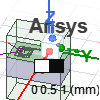

INFO 09:19PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 3
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



In [19]:
eig_res = EPRanalysis(design, "hfss")

hfss = eig_res.sim.renderer
hfss.start()

hfss.activate_ansys_design('readout','eigenmode')

hfss.render_design(['cpw_2','Q2','TQ2'],[])
hfss.save_screenshot()

setup = hfss.pinfo.setup
setup.passes = 20
setup.min_converged = 2
setup.n_modes = 3

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

In [20]:
eig_res.get_frequencies()

Design "readout" info:
	# eigenmodes    3
	# variations    1
Design "readout" info:
	# eigenmodes    3
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.161263             inf
          1        6.936875             inf
          2       20.147005             inf

In [34]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

07:31PM 31s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


INFO 10:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


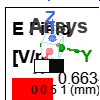

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [21]:
hfss.set_mode(1, "Setup")

hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()


In [22]:
hfss.clear_fields(['Mag_E1'])

In [23]:
hfss.set_mode(2, "Setup")

INFO 10:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


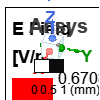

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [24]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [39]:
hfss.clear_fields(['Mag_E1'])

hfss.set_mode(3, "Setup")

INFO 07:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


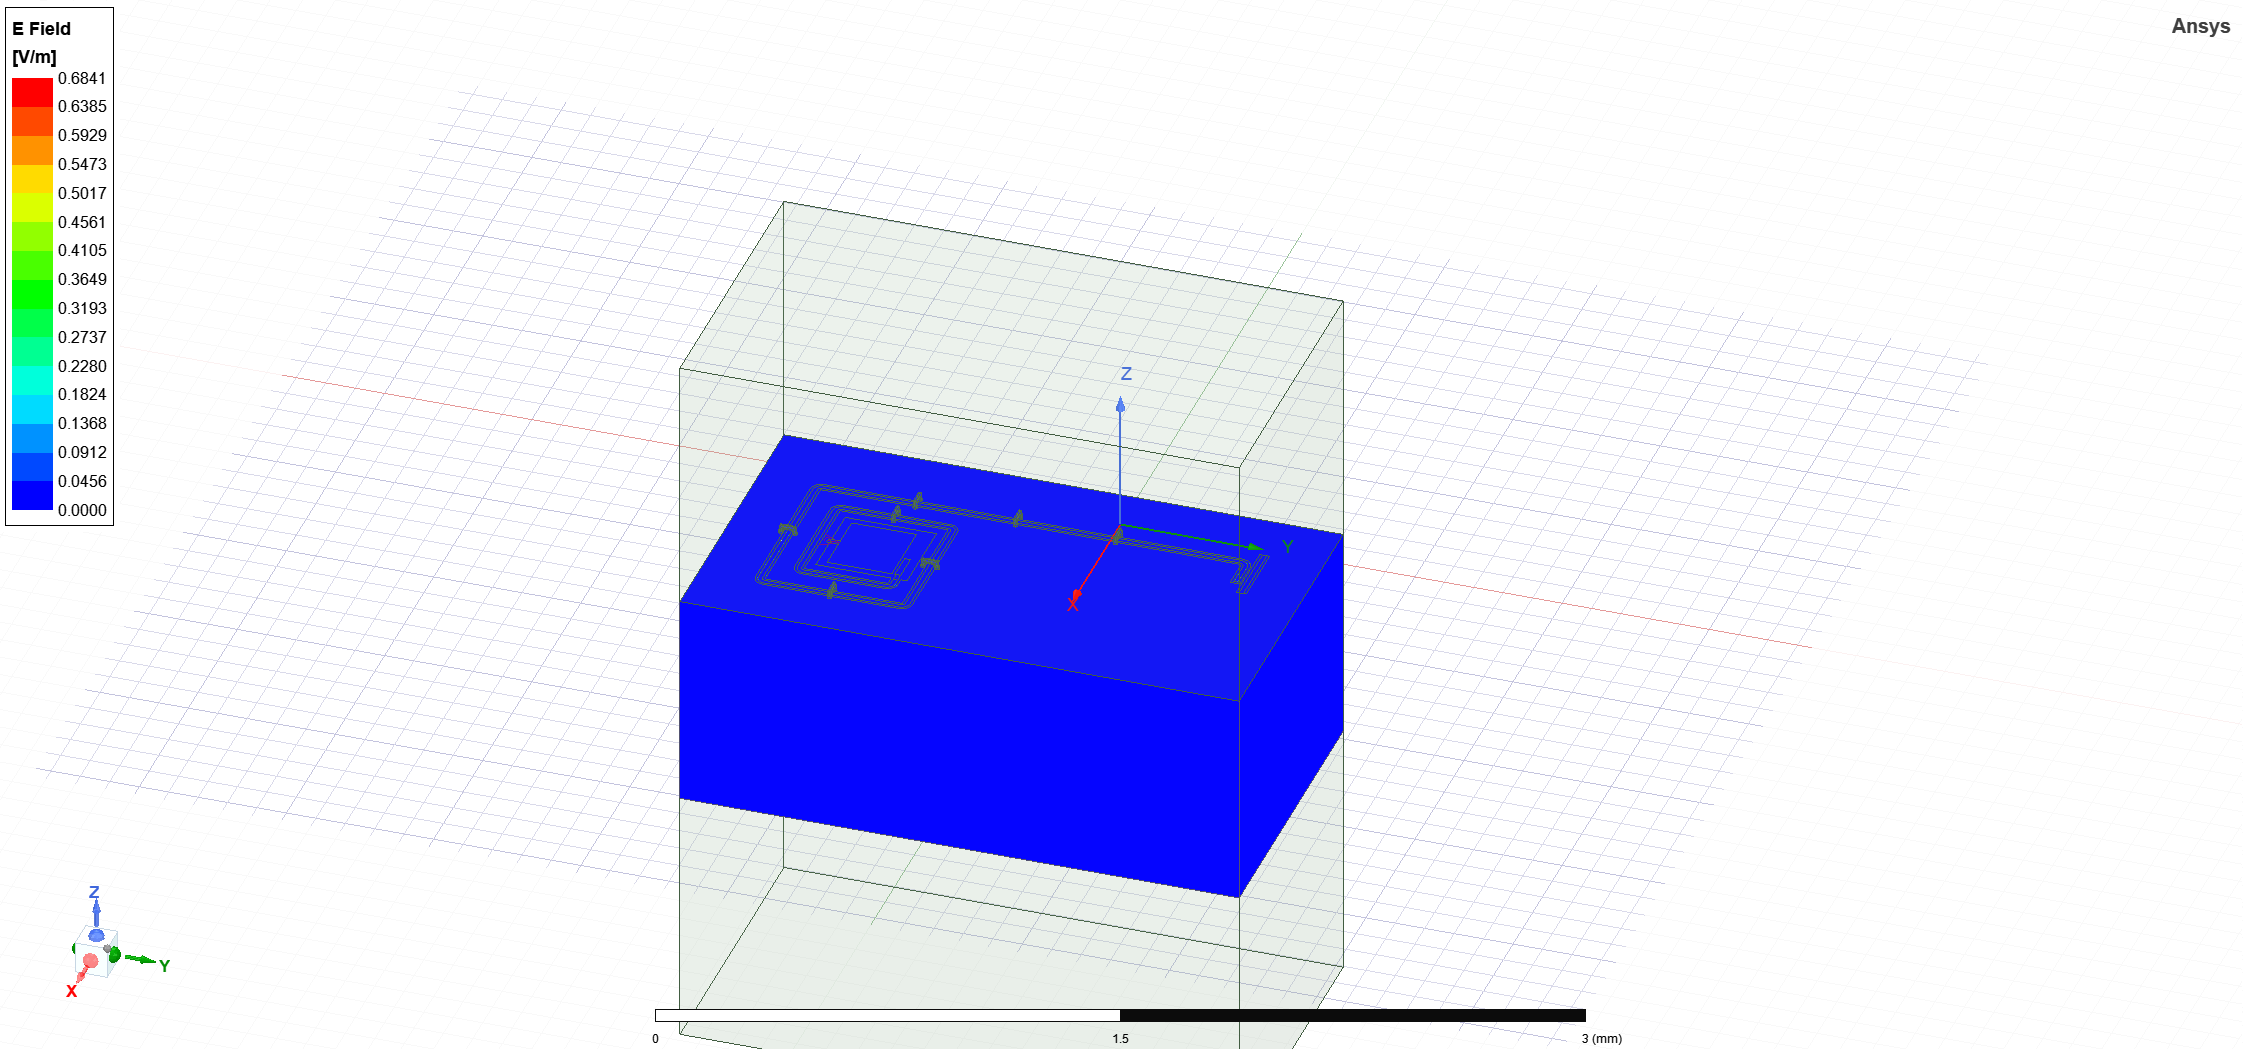

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [40]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [25]:
eig_res.sim.print_run_args()

This analysis object run with the following kwargs:
{}



In [26]:
eig_res.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'}}

In [27]:
eig_res.sim.run(name="Qbit", components=['cpw_1','Q1','TQ1','cpw_2','Q2','TQ2','cpw_middle','cpw_left','cpw_right','left','right'],
            open_terminations=[('left', 'open'),('right','open')], box_plus_buffer = False)
eig_res.sim.plot_convergences()

INFO 10:01PM [connect_design]: 	Opened active design
	Design:    Qbit_hfss [Solution type: Eigenmode]
WARNING 10:01PM [connect_setup]: 	No design setup detected.
WARNING 10:01PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:02PM [analyze]: Analyzing setup Setup
10:03PM 51s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [28]:
eig_res.sim.print_run_args()


This analysis object run with the following kwargs:
{'name': 'Qbit', 'components': ['cpw_1', 'Q1', 'TQ1', 'cpw_2', 'Q2', 'TQ2', 'cpw_middle', 'cpw_left', 'cpw_right', 'left', 'right'], 'open_terminations': [('left', 'open'), ('right', 'open')], 'port_list': None, 'jj_to_port': None, 'ignored_jjs': None, 'box_plus_buffer': False}



In [29]:
eig_res.sim.convergence_f

,re(Mode(1)) [g]
Pass [],
1,4.191686
2,4.413080
3,5.450353
4,5.677656
5,5.956687
6,6.069239
7,6.120908
8,6.143129
9,NaN


In [31]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (1.00000 -0.11500, 1.00000 -0.15500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction
1,2,rect_jj,"LINESTRING (0.39000 -0.82500, 0.39000 -0.86500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction


In [32]:
# TODO: fold this inside either an analysis class method, or inside the analysis class setup

qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

In [33]:
eig_2qb = EPRanalysis(design, "hfss")

In [34]:
# eig_res.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
# eig_res.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'
# eig_res.setup

In [35]:
eig_2qb.sim.setup.max_passes = 15
eig_2qb.sim.setup.max_delta_f = 0.05
eig_2qb.sim.setup.n_modes = 2
eig_2qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF',
                           Lj2= '13 nH', Cj2= '0 fF')
eig_2qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.05,
 'max_passes': 15,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF', 'Lj2': '13 nH', 'Cj2': '0 fF'}}

In [36]:
eig_2qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.5,
 'y_buffer_width_mm': 0.5,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 1.5,
 'wb_height': 0.7,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [38]:
eig_2qb.sim.run(name="TwoTransmons1",
                components=['cpw_1','Q1','TQ1','cpw_2','Q2','TQ2','cpw_middle','cpw_left','cpw_right','left','right'],
                open_terminations=[('left', 'open'),('right','open')])

INFO 12:15PM [connect_design]: 	Opened active design
	Design:    TwoTransmons1_hfss [Solution type: Eigenmode]
INFO 12:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:15PM [analyze]: Analyzing setup Setup
12:24PM 24s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [61]:
eig_2qb.sim.plot_convergences()

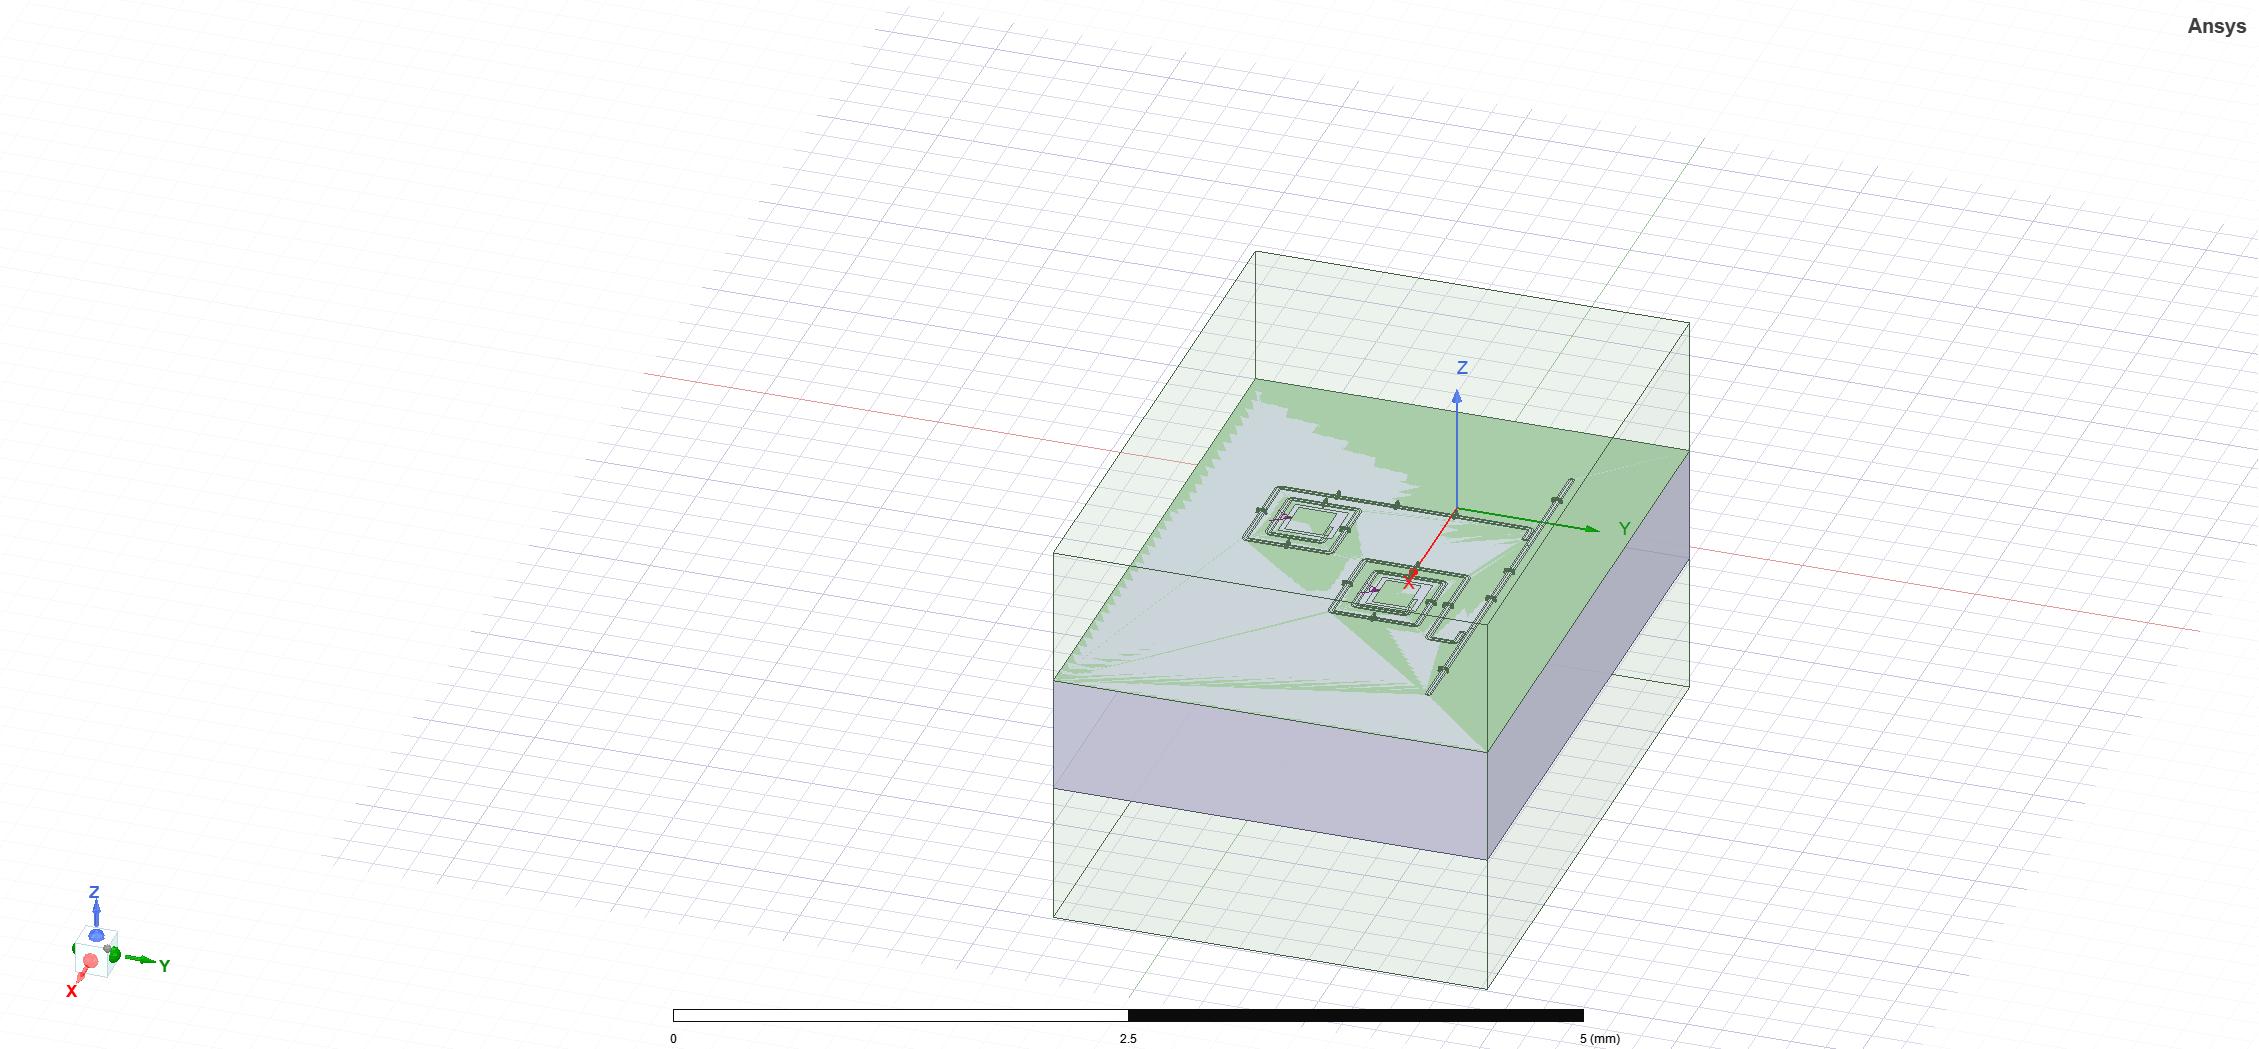

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [108]:
eig_2qb.sim.save_screenshot() 

INFO 09:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


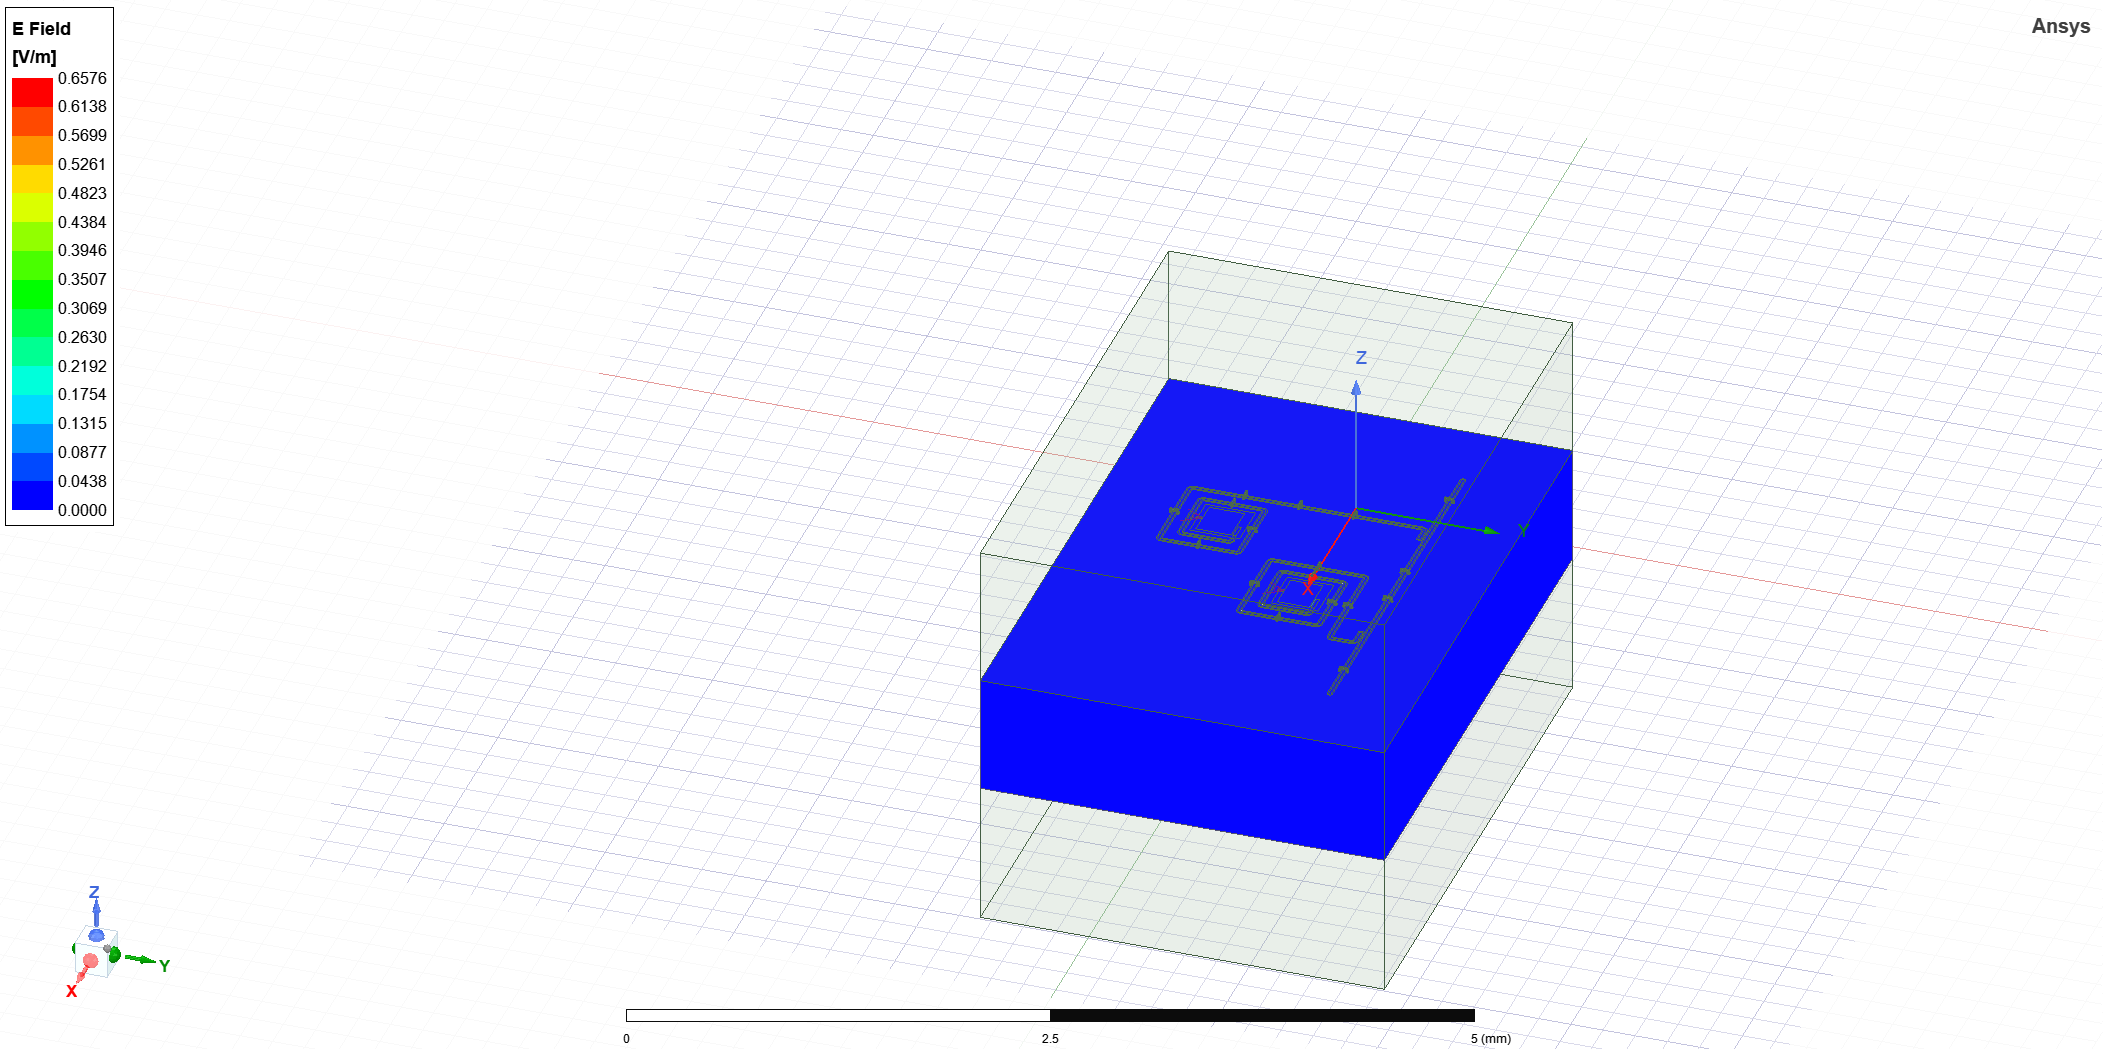

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [109]:
eig_2qb.sim.plot_fields('main', eigenmode=2)
eig_2qb.sim.save_screenshot()

In [39]:
del eig_2qb.setup.junctions['jj']

In [40]:
eig_2qb.setup.junctions

{}

In [41]:
eig_2qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
eig_2qb.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                  Lj_variable='Lj2', Cj_variable='Cj2')
eig_2qb.setup.sweep_variable = 'Lj1'
eig_2qb.setup

{'junctions': {'jj1': {'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_',
   'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1'},
  'jj2': {'rect': 'JJ_rect_Lj_Q2_rect_jj',
   'line': 'JJ_Lj_Q2_rect_jj_',
   'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

In [42]:
eig_2qb.run_epr()

Design "TwoTransmons1_hfss" info:
	# eigenmodes    2
	# variations    1
Design "TwoTransmons1_hfss" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.13735440013753e-26
        energy_elec_substrate = 7.49915282463316e-26
        EPR of substrate = 92.2%

        energy_mag    = 4.9689465590474e-27
        energy_mag % of energy_elec_all  = 6.1%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.52 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               93.9%  4.069e-26 2.484e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.96%
	jj1             0.00011968  (+)        3.74644e-06


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.96%
	jj2             0.528142  (+)        0.0165328
		(U_tot_cap-U_tot_ind)/mean=26.60%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9215713677785026


  _Om = pd.Series({})




  Mode 1 at 5.68 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               93.0%  3.629e-26 2.528e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.80%
	jj1             0.523318  (+)        0.0173069


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.80%
	jj2             0.000107066  (+)        3.54085e-06
		(U_tot_cap-U_tot_ind)/mean=26.34%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.921573706895797


  options=pd.Series(get_instance_vars(self.options)),

WARNING 12:31PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 12:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 53.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 12:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 53.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project17\TwoTransmons1_hfss\2023-02-14 12-31-09.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.777961
1    1.775421
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False   True
1   True  False
*** P (participation matrix, not normlz.)
        jj1       jj2
0  0.000118  0.519550
1  0.514413  0.000105

*** S (sign-bit matrix)
   s_jj1  s_jj2
0     -1      1
1     -1     -1
*** P (participation matrix, normalized.)
   0.00012     0.92
      0.91  0.00011

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       259    0.128
     0.128      267

*** Chi matrix ND (MHz) 
       285   -0.065
    -0.065      294

*** Frequencies O1 PT (MHz)
0    5263.679777
1    5409.005643
dtype: float64

*** Frequencies ND (MHz)
0    5251.33987
1    5396.39535
dtyp

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5251.34
1,5396.40


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0       1
Lj1                  
13  0  284.54   -0.06
    1   -0.06  293.67

In [43]:
eig_2qb.setup.sweep_variable = 'Lj2'
eig_2qb.setup

{'junctions': {'jj1': {'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_',
   'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1'},
  'jj2': {'rect': 'JJ_rect_Lj_Q2_rect_jj',
   'line': 'JJ_Lj_Q2_rect_jj_',
   'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj2'}

In [44]:
eig_2qb.run_epr()

Design "TwoTransmons1_hfss" info:
	# eigenmodes    2
	# variations    1
Design "TwoTransmons1_hfss" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.25708785234321e-26
        energy_elec_substrate = 6.68794135335239e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.05532767888777e-27
        energy_mag % of energy_elec_all  = 7.0%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.52 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               93.9%  4.069e-26 2.484e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.96%
	jj1             0.00011968  (+)        3.74644e-06


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.96%
	jj2             0.528142  (+)        0.0165328
		(U_tot_cap-U_tot_ind)/mean=26.60%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_0 = 0.9215713677785026

  Mode 1 at 5.68 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               93.0%  3.629e-26 2.528e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.80%
	jj1             0.523318  (+)        0.0173069


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.80%
	jj2             0.000107066  (+)        3.54085e-06
		(U_tot_cap-U_tot_ind)/mean=26.34%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.921573706895797


  options=pd.Series(get_instance_vars(self.options)),

WARNING 12:48PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 12:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 53.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 12:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 53.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project17\TwoTransmons1_hfss\2023-02-14 12-48-28.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.777961
1    1.775421
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False   True
1   True  False
*** P (participation matrix, not normlz.)
        jj1       jj2
0  0.000118  0.519550
1  0.514413  0.000105

*** S (sign-bit matrix)
   s_jj1  s_jj2
0     -1      1
1     -1     -1
*** P (participation matrix, normalized.)
   0.00012     0.92
      0.91  0.00011

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       259    0.128
     0.128      267

*** Chi matrix ND (MHz) 
       285   -0.065
    -0.065      294

*** Frequencies O1 PT (MHz)
0    5263.679777
1    5409.005643
dtype: float64

*** Frequencies ND (MHz)
0    5251.33987
1    5396.39535
dtyp

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj2,13
0,5251.34
1,5396.40


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0       1
Lj2                  
13  0  284.54   -0.06
    1   -0.06  293.67

## Save Design to GDS

In [51]:
a_gds = design.renderers.gds

In [52]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [53]:
a_gds.options['path_filename'] = 'Customized_Components\Fake_Junctions.GDS'

In [54]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('Two PAd design.gds')

03:13PM 51s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"c:\Users\slab\Desktop\Qiskit_metal_tutorial\tutorials\4 Analysis\resources".


1